# Data cleansing

## Import Data

In [2]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [4]:
#Menghubungkan ke database SQLite
conn = sqlite3.connect('foo.db')

In [6]:
cursor = conn.cursor() # melihat daftar semua tabel
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # membuat objek cursor dari koneksi database conn untuk mengeksekusi perintah SQL
tables = cursor.fetchall() # Menjalankan query SQL untuk mengambil semua nama tabel yang ada di dalam database SQLite
print("Daftar tabel:", tables) # Mengambil list semua hasil dari query

Daftar tabel: [('olist_customers_dataset',), ('olist_geolocation_dataset',), ('olist_orders_dataset',), ('olist_order_items_dataset',), ('olist_order_payments_dataset',), ('olist_order_reviews_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('product_category_name_translation',)]


In [8]:
# Mengambil semua tabel utama dari database Olist ke dalam DataFrame Pandas

customers = pd.read_sql_query("SELECT * FROM olist_customers_dataset", conn)
orders = pd.read_sql_query("SELECT * FROM olist_orders_dataset", conn)
order_items = pd.read_sql_query("SELECT * FROM olist_order_items_dataset", conn)
payments = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", conn)
reviews = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset", conn)
products = pd.read_sql_query("SELECT * FROM olist_products_dataset", conn)
sellers = pd.read_sql_query("SELECT * FROM olist_sellers_dataset", conn)
category_translation = pd.read_sql_query("SELECT * FROM product_category_name_translation", conn)
geo = pd.read_sql_query("SELECT * FROM olist_geolocation_dataset", conn)

conn.close() # Menutup koneksi database setelah data diambil

In [9]:
# bersihkan kolom dari karakter tersembunyi
category_translation.columns = category_translation.columns.str.replace('\ufeff', '').str.strip()

## Gabungkan dataset

In [10]:
# Gabungkan orders dengan customers
df = orders.merge(customers, on='customer_id', how='left')

# Gabungkan dengan order_items
df = df.merge(order_items, on='order_id', how='left')

# Gabungkan dengan payments
df = df.merge(payments, on='order_id', how='left')

# Gabungkan dengan reviews
df = df.merge(reviews, on='order_id', how='left')

# Gabungkan dengan products (sudah mengandung product_category_name)
df = df.merge(products, on='product_id', how='left')

# Gabungkan dengan sellers
df = df.merge(sellers, on='seller_id', how='left')

# Bersihkan nama kolom category_translation dari karakter tersembunyi
category_translation.columns = category_translation.columns.str.strip()

category_translation['product_category_name'] = category_translation['product_category_name'].str.strip()
df = df.merge(category_translation, on='product_category_name', how='left')

## Deal Null Values

In [13]:
# Tampilkan jumlah nilai yang hilang (NaN) per kolom dalam DataFrame
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date       0
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_id                         997
review_score                      997
review_comment_title              997
review_comment_message            997
review_creat

Nilai Null (NaN) Muncul di Python saat di SQL Tidak Null disebabkan oleh:
1. Hasil JOIN Tidak Cocok (Mismatched JOIN)
Meskipun tabel utama di SQL tidak memiliki null, jika kamu melakukan JOIN (terutama LEFT JOIN, RIGHT JOIN, atau FULL OUTER JOIN), maka baris yang tidak menemukan pasangan di tabel lain akan menghasilkan NULL di kolom hasil JOIN.
2. Kolom Nama Tidak Sinkron (Hidden Spaces, Encoding Error)
Kadang-kadang nama kolom atau isi datanya memiliki karakter tersembunyi, seperti:
    * Spasi di awal/akhir ('product_category_name ' vs 'product_category_name')
    * Karakter khusus (BOM - Byte Order Mark)
    * Perbedaan huruf besar kecil
    * Saat merge atau join di Python (df.merge(...)), key tidak cocok, dan baris hasil merge punya banyak NaN
3. Data Tertimpa Saat Merge
4. Saat ekspor SQL ke CSV atau langsung ke Python:
    * Tipe data tidak terbaca (misalnya datetime corrupt → NaT/NaN)
    * Encoding salah (misalnya utf-8 vs latin1)
    * Kolom tidak sesuai (header terpotong)

Untuk Memperbaiki nilai null periksa sebab terjadi null dan lakukan perbaikan.

In [16]:
print("Total baris:", len(df))
print("Customer unik:", df['customer_id'].nunique())

Total baris: 119143
Customer unik: 99441


In [18]:
# Isi atau perbaiki baris NAN sesuai arti masing-masing kolom

# Produk / Order Item — NaN berarti order tidak punya item
# Ganti NaN dengan nilai placeholder agar tidak error saat analisis
df['order_item_id'] = df['order_item_id'].fillna(-1).astype(int)
df['product_id'] = df['product_id'].fillna('unknown')
df['seller_id'] = df['seller_id'].fillna('unknown')
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'], errors='coerce')

df['price'] = df['price'].fillna(0)
df['freight_value'] = df['freight_value'].fillna(0)

# Payment — NaN artinya belum ada pembayaran
df['payment_type'] = df['payment_type'].fillna('unknown')
df['payment_installments'] = pd.to_numeric(df['payment_installments'], errors='coerce').fillna(0).astype(int)
df['payment_value'] = df['payment_value'].fillna(0)

# Review — NaN berarti belum ada review
df['review_score'] = df['review_score'].fillna(0).astype(int)
df['review_comment_title'] = df['review_comment_title'].fillna('No Title')
df['review_comment_message'] = df['review_comment_message'].fillna('No Message')
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'], errors='coerce')
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'], errors='coerce')

# Produk Detail — jika kosong, isi dengan default
df['product_category_name'] = df['product_category_name'].fillna('unknown')
df['product_category_name_english'] = df['product_category_name_english'].fillna('unknown')

df['product_name_lenght'] = pd.to_numeric(df['product_name_lenght'], errors='coerce').fillna(0).astype(int)
df['product_description_lenght'] = pd.to_numeric(df['product_description_lenght'], errors='coerce').fillna(0).astype(int)
df['product_photos_qty'] = pd.to_numeric(df['product_photos_qty'], errors='coerce').fillna(0).astype(int)

df['product_weight_g'] = df['product_weight_g'].fillna(0)
df['product_length_cm'] = df['product_length_cm'].fillna(0)
df['product_height_cm'] = df['product_height_cm'].fillna(0)
df['product_width_cm'] = df['product_width_cm'].fillna(0)

# Seller info
df['seller_zip_code_prefix'] = df['seller_zip_code_prefix'].fillna(-1).astype(int)
df['seller_city'] = df['seller_city'].fillna('unknown')
df['seller_state'] = df['seller_state'].fillna('unknown')

df.drop(['shipping_limit_date', 'review_id', 'review_creation_date', 'review_answer_timestamp','payment_sequential'], axis=1, inplace=True)

In [20]:
df.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
payment_type                     0
payment_installments             0
payment_value                    0
review_score                     0
review_comment_title             0
review_comment_message           0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm   

In [22]:
print("Total baris:", len(df))
print("Customer unik:", df['customer_id'].nunique())

Total baris: 119143
Customer unik: 99441


# Add Column

## Tambahkan kolom berdasarkan periode waktu

In [24]:
#lihat isi dan struktur data
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,178,1,400,19,13,19,31570,belo horizonte,SP,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,232,1,420,24,19,21,14840,guariba,SP,auto


In [26]:
#lihat deskripsi data
df.describe()

,order_item_id,payment_installments,review_score,product_name_lenght,product_description_lenght,product_photos_qty,seller_zip_code_prefix
count,119143.000000,119143.000000,119143.00000,119143.000000,119143.000000,119143.000000,119143.000000
mean,1.181186,2.941172,3.98198,47.727009,769.198644,2.158113,24271.511906
std,0.720667,2.777852,1.44174,12.173079,655.498851,1.728654,27551.827480
min,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,1.000000,3.00000,42.000000,338.000000,1.000000,6236.000000
50%,1.000000,2.000000,5.00000,51.000000,590.000000,1.000000,13500.000000
75%,1.000000,4.000000,5.00000,57.000000,971.000000,3.000000,27277.000000
max,21.000000,24.000000,5.00000,76.000000,3992.000000,20.000000,99730.000000


In [30]:
# Ubah 'order_purchase_timestamp' menjadi Datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,268,4,500,19,8,13,9350,maua,SP,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,178,1,400,19,13,19,31570,belo horizonte,SP,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,232,1,420,24,19,21,14840,guariba,SP,auto


## Tambah kolom Tahun, Bulan, Tanggal, Hari dan Jam

In [32]:
df['year'] = df['order_purchase_timestamp'].dt.year # buat kolom tahun
df['month'] = df['order_purchase_timestamp'].dt.month # buat kolom bulan
df['day'] = df['order_purchase_timestamp'].dt.day # buat kolom tanggal
df['day_name'] = df['order_purchase_timestamp'].dt.day_name() # buat kolom hari
df['hour'] = df['order_purchase_timestamp'].dt.hour # buat kolom jam
df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) # buat kolom waktu
df.sample(2) #melihat 2 sample data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,year,month,day,day_name,hour,date
87219,b6adeda1430443497b0126dd0877e7c1,1c78a9d0b5bcf38712fb4465d10d83fa,delivered,2017-05-26 11:15:31,2017-05-26 11:25:13,2017-06-09 14:07:34,2017-06-14 14:44:03,2017-06-08 00:00:00,2467b4330b80b91a5b382507a756fcf9,08410,...,5424,sao paulo,SP,housewares,2017,5,26,Friday,11,2017-05-26
55650,bd80a1b56163c6fcce585462d490ab36,7ef2f20ace2fc981f95637413c5782f4,delivered,2018-07-20 14:35:51,2018-07-20 14:45:19,2018-07-27 07:45:00,2018-08-03 20:27:41,2018-08-14 00:00:00,f70b29c275d50a814047d1db1fe0417c,90110,...,7242,guarulhos,SP,furniture_decor,2018,7,20,Friday,14,2018-07-20


## Add columns based on the actual price the customer purchased

In [34]:
# Tambahkan kolom berdasarkan harga sebenarnya yang dibeli pelanggan
# Ubah ke float64, nilai tak valid jadi NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['freight_value'] = pd.to_numeric(df['freight_value'], errors='coerce')

# Sekarang buat kolom baru total
df['total_price_value'] = df['price']
df['total_freight_value'] = df['freight_value']
df['total_order_value'] = df['price']+df['freight_value']

df.sample(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_category_name_english,year,month,day,day_name,hour,date,total_price_value,total_freight_value,total_order_value
24124,5a8cbabf9050846cfba3b3f011e2cad0,9c00a1f34ce8322426a443a43c8b0347,delivered,2018-06-10 14:26:44,2018-06-10 14:57:04,2018-06-11 15:22:00,2018-06-13 18:52:48,2018-06-20 00:00:00,04f2b3af34d63daf3623b1ff65293459,07172,...,cool_stuff,2018,6,10,Sunday,14,2018-06-10,265.0,21.90,286.90
56167,526ad2823ac462d2de62d9747db765e6,36a8a446b9a461c4ad8763d0e314efd1,delivered,2018-01-11 12:06:58,2018-01-12 12:08:40,2018-01-13 01:08:55,2018-01-19 18:19:09,2018-02-08 00:00:00,0bd3d5b6cf491c4bb0712be5161ebc32,29600,...,cool_stuff,2018,1,11,Thursday,12,2018-01-11,848.0,23.19,871.19


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              119143 non-null  object        
 5   order_delivered_carrier_date   119143 non-null  object        
 6   order_delivered_customer_date  119143 non-null  object        
 7   order_estimated_delivery_date  119143 non-null  object        
 8   customer_unique_id             119143 non-null  object        
 9   customer_zip_code_prefix       119143 non-null  object        
 10  customer_city                  119143 non-null  object        
 11  

In [38]:
df.describe()

,order_purchase_timestamp,order_item_id,price,freight_value,payment_installments,review_score,product_name_lenght,product_description_lenght,product_photos_qty,seller_zip_code_prefix,year,month,day,hour,date,total_price_value,total_freight_value,total_order_value
count,119143,119143.000000,119143.000000,119143.000000,119143.000000,119143.00000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143,119143.000000,119143.000000,119143.000000
mean,2017-12-29 18:36:13.115760128,1.181186,119.803091,19.892328,2.941172,3.98198,47.727009,769.198644,2.158113,24271.511906,2017.535290,6.033086,15.551321,14.755537,2017-12-29 03:20:51.024398848,119.803091,19.892328,139.695419
min,2016-09-04 21:15:19,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,2016.000000,1.000000,1.000000,0.000000,2016-09-04 00:00:00,0.000000,0.000000,0.000000
25%,2017-09-10 20:15:46,1.000000,39.900000,12.950000,1.000000,3.00000,42.000000,338.000000,1.000000,6236.000000,2017.000000,3.000000,8.000000,11.000000,2017-09-10 00:00:00,39.900000,12.950000,54.790000
50%,2018-01-17 11:59:12,1.000000,73.900000,16.240000,2.000000,5.00000,51.000000,590.000000,1.000000,13500.000000,2018.000000,6.000000,16.000000,15.000000,2018-01-17 00:00:00,73.900000,16.240000,91.230000
75%,2018-05-03 13:18:30,1.000000,132.700000,21.150000,4.000000,5.00000,57.000000,971.000000,3.000000,27277.000000,2018.000000,8.000000,23.000000,19.000000,2018-05-03 00:00:00,132.700000,21.150000,157.210000
max,2018-10-17 17:30:18,21.000000,6735.000000,409.680000,24.000000,5.00000,76.000000,3992.000000,20.000000,99730.000000,2018.000000,12.000000,31.000000,23.000000,2018-10-17 00:00:00,6735.000000,409.680000,6929.310000
std,NaN,0.720667,183.740150,15.869417,2.777852,1.44174,12.173079,655.498851,1.728654,27551.827480,0.505591,3.233819,8.664547,5.327825,NaN,183.740150,15.869417,190.930352


In [157]:
# Simpan ke file CSV
df.to_csv('gabungan_olist.csv', index=False)

# Customer Demographic

## Change the name of the state and city columns to address static and address city

In [35]:
df.rename(columns={'customer_city':'address_city', 'customer_state':'address_static'},inplace=True) #ubah nama customer city dan customer state
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_category_name_english,year,month,day,day_name,hour,date,total_price_value,total_freight_value,total_order_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,housewares,2017,10,2,Monday,10,2017-10-02,29.99,8.72,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,housewares,2017,10,2,Monday,10,2017-10-02,29.99,8.72,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,housewares,2017,10,2,Monday,10,2017-10-02,29.99,8.72,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,perfumery,2018,7,24,Tuesday,20,2018-07-24,118.70,22.76,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,auto,2018,8,8,Wednesday,8,2018-08-08,159.90,19.22,179.12


In [37]:
print(df['address_static'].str.strip().str.upper().unique())

['SP' 'BA' 'GO' 'RN' 'PR' 'RS' 'RJ' 'MG' 'SC' 'RR' 'PE' 'TO' 'CE' 'DF'
 'SE' 'MT' 'PB' 'PA' 'RO' 'ES' 'AP' 'MS' 'MA' 'PI' 'AL' 'AC' 'AM']


In [39]:
state_mapping = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'}

# Bersihkan data dan ubah ke huruf besar jika perlu
df['address_static'] = df['address_static'].str.strip().str.upper()

# Lakukan mapping ke nama lengkap
df['address_static'] = df['address_static'].map(state_mapping)
df['address_static']

0              São Paulo
1              São Paulo
2              São Paulo
3                  Bahia
4                  Goiás
               ...      
119138         São Paulo
119139             Bahia
119140    Rio de Janeiro
119141    Rio de Janeiro
119142            Paraná
Name: address_static, Length: 119143, dtype: object

In [166]:
# Simpan ke file CSV
df.to_csv('gabungan_olist.csv', index=False)

## Total id pelanggan unik berdasarkan kota alamat dan visualisasinya

In [41]:
df.groupby('address_city').agg({'customer_unique_id':'nunique','order_id':'nunique','total_order_value':'sum'}).sort_values('customer_unique_id',ascending=False)

,customer_unique_id,order_id,total_order_value
address_city,,,
sao paulo,14984,15540,2290149.11
rio de janeiro,6620,6882,1208044.44
belo horizonte,2672,2773,432683.29
brasilia,2069,2131,366678.41
curitiba,1465,1521,253307.86
...,...,...,...
ibertioga,1,1,181.21
ibiajara,1,1,131.60
ibiara,1,1,321.98


<Axes: xlabel='address_city'>

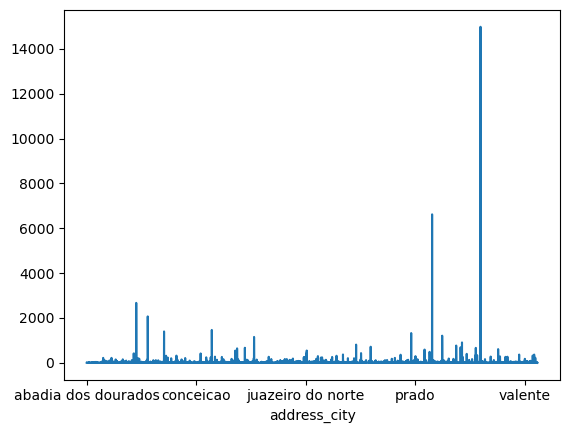

In [43]:
df.groupby('address_city')['customer_unique_id'].nunique().plot()

## Total pesanan tiap pelanggan

<Axes: title={'center': 'Histogram of Order Frequency'}, ylabel='Frequency'>

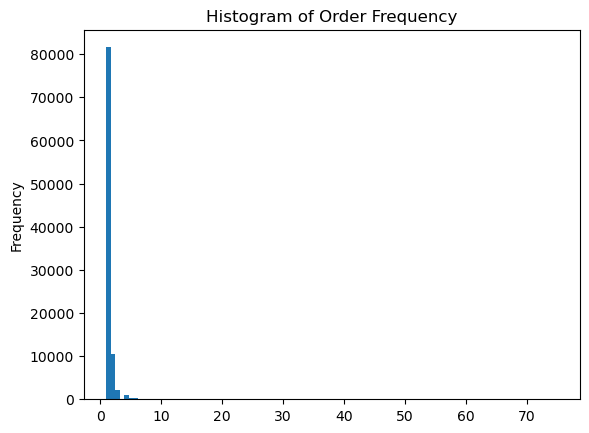

In [45]:
df_frequency = df.groupby('customer_unique_id').agg({'order_id': 'count'})
df_frequency['order_id'].plot(kind='hist', bins=100, title='Histogram of Order Frequency')

In [47]:
df_frequency = df.groupby('customer_unique_id').agg(order_count=('order_id', 'count'))
df_frequency.sort_values('order_count',ascending=False)

,order_count
customer_unique_id,
9a736b248f67d166d2fbb006bcb877c3,75
6fbc7cdadbb522125f4b27ae9dee4060,38
f9ae226291893fda10af7965268fb7f6,35
8af7ac63b2efbcbd88e5b11505e8098a,29
569aa12b73b5f7edeaa6f2a01603e381,26
...,...
5b9f3a22a2f637041e498817b1e956cd,1
5b9e2d80a7ebfcf10ed0fa934a6de8f9,1
5b9ded8428365feb7e1eac3fc3085132,1


### kategori frekuensi pesanan untuk setiap pelanggan

In [49]:
# asumsi = jika di bawah sama dengan 5 maka disebut sedikit, jika tidak maka disebut banyak
df_frequency['F_score']=pd.cut(df_frequency['order_count'],bins=[0,5,np.inf],labels=['Little','Lot'],right=True)
df_frequency

,order_count,F_score
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,Little
0000b849f77a49e4a4ce2b2a4ca5be3f,1,Little
0000f46a3911fa3c0805444483337064,1,Little
0000f6ccb0745a6a4b88665a16c9f078,1,Little
0004aac84e0df4da2b147fca70cf8255,1,Little
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,Little
fffea47cd6d3cc0a88bd621562a9d061,1,Little
ffff371b4d645b6ecea244b27531430a,1,Little


In [51]:
# ringkasan statistik berdasarkan skor frekuensi pelanggan
df_frequency.groupby('F_score').agg({'order_count':['min','max','mean','median','count']})

C:\Users\sahar\AppData\Local\Temp\ipykernel_37208\1407457360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequency.groupby('F_score').agg({'order_count':['min','max','mean','median','count']})


order_count                            
                min max      mean median  count
F_score                                        
Little            1   5  1.198390    1.0  95524
Lot               6  75  8.160839    6.0    572

## Total pesanan antara tanggal pembelian terakhir dan tanggal pembelian pertama

In [53]:
latest_date=df['date'].max() #ambil tanggal paling akhir
latest_transaction_per_cust= df.sort_values('date').groupby('customer_unique_id').tail(1) #ambil transaksi terbaru setelah tanggal diurutkan
latest_transaction_per_cust['days_to_today']= latest_date-latest_transaction_per_cust['date'] #hitung jarak hari antara transaksi 
latest_transaction_per_cust['days_to_today'] #tampilkan kolom hasil

5360     773 days
5198     772 days
11996    764 days
36865    762 days
99376    745 days
           ...   
60308     18 days
105869    16 days
38270     14 days
81748      1 days
72820      0 days
Name: days_to_today, Length: 96096, dtype: timedelta64[ns]

In [55]:
# ubah kolom days_to_today dari tipe Timedelta menjadi tipe int yang berisi jumlah hari (integer) 
latest_transaction_per_cust['days_to_today'] = latest_transaction_per_cust['days_to_today'].dt.days
latest_transaction_per_cust

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,year,month,day,day_name,hour,date,total_price_value,total_freight_value,total_order_value,days_to_today
5360,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,,2016-10-20 00:00:00,b7d76e111c89f7ebf14761390f0f7d17,69309,...,2016,9,4,Sunday,21,2016-09-04,32.90,31.67,64.57,773
5198,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,,,2016-10-28 00:00:00,4854e9b3feff728c13ee5fc7d1547e92,99025,...,2016,9,5,Monday,0,2016-09-05,59.50,15.56,75.06,772
11996,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,,,2016-09-30 00:00:00,009b0127b727ab0ba422f6d9604487c7,12244,...,2016,9,13,Tuesday,15,2016-09-13,0.00,0.00,0.00,764
36865,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23,14600,...,2016,9,15,Thursday,12,2016-09-15,44.99,2.83,47.82,762
99376,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,,,2016-10-25 00:00:00,0eb1ee9dba87f5b36b4613a65074337c,02975,...,2016,10,2,Sunday,22,2016-10-02,100.00,9.34,109.34,745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60308,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,,,,2018-10-15 00:00:00,9bb92bebd4cb7511e1a02d5e50bc4655,07176,...,2018,9,29,Saturday,9,2018-09-29,0.00,0.00,0.00,18
105869,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,,,,2018-10-23 00:00:00,634420a0ea42302205032ed44ac7fccc,27175,...,2018,10,1,Monday,15,2018-10-01,0.00,0.00,0.00,16
38270,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,,,,2018-10-16 00:00:00,af5454198a97379394cacf676e1e96cb,11900,...,2018,10,3,Wednesday,18,2018-10-03,0.00,0.00,0.00,14
81748,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,,,,2018-11-12 00:00:00,262e1f1e26e92e86375f86840b4ffd63,64600,...,2018,10,16,Tuesday,20,2018-10-16,0.00,0.00,0.00,1


<Axes: ylabel='Frequency'>

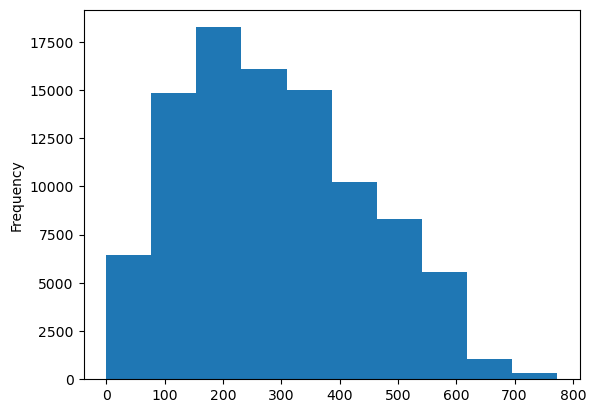

In [57]:
# Buat visualisasi untuk melihat distribusi recency
df_recency=latest_transaction_per_cust[['customer_unique_id','days_to_today']]
df_recency['days_to_today'].plot(kind='hist')

Dari diagram dilihat bahwa kebanyakan orang baru melakukan transaksi dan yang paling lama 729 hari tidak melakukan transaksi

In [59]:
# buat segmentasi pelanggan berdasarkan recency menjadi Recently, Normal, dan Long
df_recency['R_score']=pd.qcut(df_recency['days_to_today'],3, labels=['Recently','Normal','Long'])
df_recency.sample(5)

C:\Users\sahar\AppData\Local\Temp\ipykernel_37208\3139134482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency['R_score']=pd.qcut(df_recency['days_to_today'],3, labels=['Recently','Normal','Long'])


,customer_unique_id,days_to_today,R_score
5294,6f0b3c0824512f9e29805095537bd68d,398,Long
10340,d28f1911eb7512d55b432187bb397973,61,Recently
42592,340dadff945403735c1e1194312527b8,68,Recently
1411,43edb5e13058ed02b2828267451ae295,90,Recently
105273,165a8bdaa0c1c792e220ea116f9c6d50,270,Normal


In [61]:
# ringkasan statistik berdasarkan skor recency
df_recency.groupby('R_score').agg({'days_to_today':['min','max','median','mean','count']})

C:\Users\sahar\AppData\Local\Temp\ipykernel_37208\4109857678.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recency.groupby('R_score').agg({'days_to_today':['min','max','median','mean','count']})


days_to_today                               
                   min  max median        mean  count
R_score                                              
Recently             0  198  126.0  125.084675  32052
Normal             199  341  269.0  270.647000  32170
Long               342  773  458.0  469.667284  31874

## Kongklusi

In [65]:
# RF Analysis
Recency = df_recency.set_index('customer_unique_id')['R_score']
Frequency = df_frequency['F_score']
df_rf = pd.concat([Recency, Frequency], axis=1)
df_rf

,R_score,F_score
customer_unique_id,,
b7d76e111c89f7ebf14761390f0f7d17,Long,Little
4854e9b3feff728c13ee5fc7d1547e92,Long,Little
009b0127b727ab0ba422f6d9604487c7,Long,Little
830d5b7aaa3b6f1e9ad63703bec97d23,Long,Little
0eb1ee9dba87f5b36b4613a65074337c,Long,Little
...,...,...
9bb92bebd4cb7511e1a02d5e50bc4655,Recently,Little
634420a0ea42302205032ed44ac7fccc,Recently,Little
af5454198a97379394cacf676e1e96cb,Recently,Little


In [67]:
df_rf.value_counts() #menghitung jumlah kemunculan per kategori

R_score   F_score
Normal    Little     31989
Recently  Little     31862
Long      Little     31673
          Lot          201
Recently  Lot          190
Normal    Lot          181
Name: count, dtype: int64

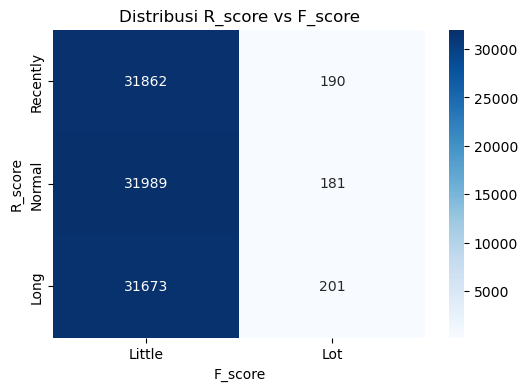

In [71]:
# Visualization
df_counts = df_rf.value_counts().reset_index(name='Count')

# Heatmap
pivot_df = df_counts.pivot(index="R_score", columns="F_score", values="Count")

plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="Blues")
plt.title("Distribusi R_score vs F_score")
plt.show()

Berdasarkan hasil Analisis yang dilakukan dapat dilihat bahwa:
1. Mayoritas pelanggan termasuk kategori Little Frequency (frekuensi rendah):
   * Total pelanggan dengan F_score = Little: 31.989 + 31.862 + 31.673 = 95.524 pelanggan (hampir seluruh pelanggan).
   * Hanya 572 pelanggan (201+190+181) yang memiliki frekuensi tinggi (Lot).
   * Ini menunjukkan bahwa pelanggan jarang bertransaksi ulang (retensi rendah).
2. Distribusi berdasarkan Recency (R_score):
   * Recently–Little (31,862): pelanggan baru tetapi frekuensi masih rendah.
   * Normal–Little (31,989): transaksi tidak terlalu baru dan juga jarang.
   * Long–Little (31,673): sudah lama tidak transaksi dan juga jarang → ini paling berisiko churn.
   * Lot paling banyak dimiliki oleh pelanggan Long (201), tapi jumlahnya sangat kecil → outlier pelanggan loyal lama.

Untuk itu diperlukan strategi:
1. Fokus Peningkatan Retensi Pelanggan Frekuensi Rendah dengan cara:
   * Kirim konten edukasi produk, ulasan, dan testimonial pelanggan
   * Berikan notifikasi menarik seperti “Diskon Khusus untuk Pembelian Kedua!”
   * Kirim pengingat berkala, highlight produk baru atau produk yang pernah dibeli.
2. Mitigasi Risiko Churn di Segmen Long–Little
3. Loyalty Program untuk pelanggan dengan jumlah frequensi tinggi untuk meningkatkan loyalitas customer

# Order Behaviour

## Pengelompokan rata-rata jumlah item yang dipesan berdasarkan total pelanggan

In [200]:
# lihat frequensi pemesanan setiap customer
df_frequency = df.groupby('customer_unique_id').agg(order_count=('order_id', 'count'))
df_frequency.sort_values('order_count',ascending=False)

,order_count
customer_unique_id,
9a736b248f67d166d2fbb006bcb877c3,75
6fbc7cdadbb522125f4b27ae9dee4060,38
f9ae226291893fda10af7965268fb7f6,35
8af7ac63b2efbcbd88e5b11505e8098a,29
569aa12b73b5f7edeaa6f2a01603e381,26
...,...
5b9f3a22a2f637041e498817b1e956cd,1
5b9e2d80a7ebfcf10ed0fa934a6de8f9,1
5b9ded8428365feb7e1eac3fc3085132,1


In [202]:
# klasifikasikan customer berdasarkan frequensi pesanan
df_frequency['F_score']=pd.cut(df_frequency['order_count'],bins=[0,5,np.inf],labels=['Little','Lot'],right=True)
df_frequency

,order_count,F_score
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,Little
0000b849f77a49e4a4ce2b2a4ca5be3f,1,Little
0000f46a3911fa3c0805444483337064,1,Little
0000f6ccb0745a6a4b88665a16c9f078,1,Little
0004aac84e0df4da2b147fca70cf8255,1,Little
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,Little
fffea47cd6d3cc0a88bd621562a9d061,1,Little
ffff371b4d645b6ecea244b27531430a,1,Little


In [204]:
#lihat rata rata frequensi pemesanan berdasarkan klasifikasi
df_frequency.groupby('F_score').agg({'order_count':['mean']})

C:\Users\sahar\AppData\Local\Temp\ipykernel_13360\2629675069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequency.groupby('F_score').agg({'order_count':['mean']})


,order_count
,mean
F_score,
Little,1.198390
Lot,8.160839


In [206]:
df.describe()

,order_purchase_timestamp,order_item_id,price,freight_value,payment_installments,review_score,product_name_lenght,product_description_lenght,product_photos_qty,seller_zip_code_prefix,year,month,day,hour,date,total_price_value,total_freight_value,total_order_value
count,119143,119143.000000,119143.000000,119143.000000,119143.000000,119143.00000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143.000000,119143,119143.000000,119143.000000,119143.000000
mean,2017-12-29 18:36:13.115760128,1.181186,119.803091,19.892328,2.941172,3.98198,47.727009,769.198644,2.158113,24271.511906,2017.535290,6.033086,15.551321,14.755537,2017-12-29 03:20:51.024398848,119.803091,19.892328,139.695419
min,2016-09-04 21:15:19,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,2016.000000,1.000000,1.000000,0.000000,2016-09-04 00:00:00,0.000000,0.000000,0.000000
25%,2017-09-10 20:15:46,1.000000,39.900000,12.950000,1.000000,3.00000,42.000000,338.000000,1.000000,6236.000000,2017.000000,3.000000,8.000000,11.000000,2017-09-10 00:00:00,39.900000,12.950000,54.790000
50%,2018-01-17 11:59:12,1.000000,73.900000,16.240000,2.000000,5.00000,51.000000,590.000000,1.000000,13500.000000,2018.000000,6.000000,16.000000,15.000000,2018-01-17 00:00:00,73.900000,16.240000,91.230000
75%,2018-05-03 13:18:30,1.000000,132.700000,21.150000,4.000000,5.00000,57.000000,971.000000,3.000000,27277.000000,2018.000000,8.000000,23.000000,19.000000,2018-05-03 00:00:00,132.700000,21.150000,157.210000
max,2018-10-17 17:30:18,21.000000,6735.000000,409.680000,24.000000,5.00000,76.000000,3992.000000,20.000000,99730.000000,2018.000000,12.000000,31.000000,23.000000,2018-10-17 00:00:00,6735.000000,409.680000,6929.310000
std,NaN,0.720667,183.740150,15.869417,2.777852,1.44174,12.173079,655.498851,1.728654,27551.827480,0.505591,3.233819,8.664547,5.327825,NaN,183.740150,15.869417,190.930352


## Pengelompokan berat rata-rata barang dan simpangan baku berat barang

In [208]:
# calculates average item weight and standard deviation of item weight

# 1. Konversi kolom product_weight_g ke tipe numerik
df['product_weight_g'] = pd.to_numeric(df['product_weight_g'], errors='coerce')

# 2. Buang data yang weight-nya tidak valid (NaN)
df_clean = df.dropna(subset=['product_weight_g'])

# 3. Buat tabel agregasi rata-rata dan standar deviasi per produk
df_item_weight_stats = df_clean.groupby('product_id').agg(
    item_weight_average=('product_weight_g', 'mean'),
    item_weight_std=('product_weight_g', 'std'),
    count=('product_weight_g', 'count')  # tambahan: berapa banyak datanya
).reset_index()

# 4. (Opsional) Urutkan berdasarkan berat rata-rata tertinggi
df_item_weight_stats_sorted = df_item_weight_stats.sort_values('item_weight_average', ascending=False)
df_item_weight_stats_sorted

,product_id,item_weight_average,item_weight_std,count
5077,26644690fde745fc4654719c3904e1db,40425.0,0.0,3
7042,363a9f5b97bf194da23858be722a7aa5,30000.0,0.0,3
16844,8250ed49c0929b233a405e3ece4ce328,30000.0,NaN,1
27841,d7f8b7443f6ae5796dabe493521a1e79,30000.0,0.0,2
25139,c388dd6e3dccf434053adacfc3b5108d,30000.0,0.0,2
...,...,...,...,...
16719,81781c0fed9fe1ad6e8c81fca1e1cb08,0.0,NaN,1
7098,36ba42dd187055e1fbe943b2d11430ca,0.0,0.0,2
29658,e673e90efa65a5409ff4196c038bb5af,0.0,0.0,4
16578,8038040ee2a71048d4bdbbdc985b69ab,0.0,NaN,1


## Waktu pemesanan paling sering

In [210]:
#kelompokkan waktu menjadi Morning, Afternoon, Evening dan Night
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

#Hitung frekuensi berdasarkan bulan, hari, dan time of day
df_order_freq = df.groupby(['month', 'day', 'time_of_day']).size().reset_index(name='order_count')

# Ambil waktu paling sering dipesan per bulan dan hari
df_most_frequent = df_order_freq.sort_values('order_count', ascending=False)
print(df_most_frequent)

      month  day time_of_day  order_count
1308     11   24   Afternoon          479
1311     11   24       Night          431
1310     11   24     Morning          313
852       8    2   Afternoon          302
792       7   18   Afternoon          266
...     ...  ...         ...          ...
1001      9    8     Evening            9
1429     12   24     Evening            9
1430     12   24     Morning            7
1457     12   31     Evening            7
1278     11   16     Morning            3

[1460 rows x 4 columns]


Dari hasil yang didapatkan mayoritas pelanggan melakukan transaksi pada siang hari, kemungkinan besar saat istirahat kerja atau waktu santai.
1. Afternoon (Siang) adalah waktu dengan jumlah pesanan tertinggi.
2. Night (Malam) dan Morning (Pagi) juga menunjukkan volume tinggi, tapi umumnya lebih rendah dari Afternoon.
3. Evening (Sore) cenderung paling rendah, terlihat dari banyaknya hari dengan order count di bawah 10
4. Puncak Penjualan Terjadi di Bulan November

Rekomendasi Strategi Bisnis
1. Tingkatkan promosi dan stok produk pada waktu puncak penjualan: terutama siang hari di bulan-bulan besar seperti November.
2. Optimalkan kampanye iklan dan flash sale pada Afternoon, karena traffic-nya paling tinggi.
3. Analisis lebih lanjut bulan Juli–Oktober, karena puncaknya tidak setinggi November — bisa jadi peluang untuk promosi tambahan.
4. Tingkatkan engagement pada waktu sepi (Evening dan akhir bulan) melalui diskon waktu terbatas atau notifikasi push marketing.

## Pengelompokan nilai total pesanan rata-rata per pesanan

In [212]:
# Hitung total nilai pesanan rata-rata per pelanggan
df_avg_order_value = df.groupby('customer_id').agg(avg_order_value=('total_order_value', 'mean')).reset_index()
df_avg_order_value.sort_values('avg_order_value', ascending=False)

,customer_id,avg_order_value
77522,c6e2731c5b391845f6800c97401a43a9,6929.31
95124,f48d464a0baaea338cb25f816991ab1f,6922.21
24771,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66
86908,df55c14d1476a9a3467f131269c2477f,4950.34
14282,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34
...,...,...
29654,4c82b862da252196bc8936f210aadc8b,0.00
4124,0ab5ac09913dfd3f247c7929a3799799,0.00
17601,2d6272fc5e22facb8937eba512bad93f,0.00
4188,0adc3e20e5189e89caeceafdbcb0646e,0.00


### Klasifikasi pesanan berdasar harga

In [214]:
#asumsi harga di atas 2500 disebut mahal, harga antara 1000 - 2500 disebut normal, harga di bawah 1000 disebut murah
df_avg_order_value['Clacifies_score']=pd.cut(df_avg_order_value['avg_order_value'],bins=[0,1000,2500,np.inf],labels=['Cheap','Normal','Expensive'],right=True)
df_avg_order_value

,customer_id,avg_order_value,Clacifies_score
0,00012a2ce6f8dcda20d059ce98491703,114.74,Cheap
1,000161a058600d5901f007fab4c27140,67.41,Cheap
2,0001fd6190edaaf884bcaf3d49edf079,195.42,Cheap
3,0002414f95344307404f0ace7a26f1d5,179.35,Cheap
4,000379cdec625522490c315e70c7a9fb,107.01,Cheap
...,...,...,...
99436,fffecc9f79fd8c764f843e9951b11341,81.36,Cheap
99437,fffeda5b6d849fbd39689bb92087f431,63.13,Cheap
99438,ffff42319e9b2d713724ae527742af25,214.13,Cheap
99439,ffffa3172527f765de70084a7e53aae8,22.75,Cheap


In [216]:
# ringkasan statistik berdasarkan klasifikasi harga
df_avg_order_value.groupby('Clacifies_score').agg({'avg_order_value':['min','max','mean','median','count']})

C:\Users\sahar\AppData\Local\Temp\ipykernel_13360\3756363586.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_order_value.groupby('Clacifies_score').agg({'avg_order_value':['min','max','mean','median','count']})


avg_order_value                                       
                            min      max         mean    median  count
Clacifies_score                                                       
Cheap                  9.341429   997.54   132.210299    95.180  97704
Normal              1002.710000  2467.33  1425.109542  1325.440    896
Expensive           2512.530000  6929.31  3358.921818  3032.905     66

Sebagian besar pelanggan membeli dengan harga murah. Kemungkinan dikarenakan:
1. Profil Konsumen Sensitif Harga, pelanggan berasal dari segmen menengah ke bawah atau komunitas yang lebih mempertimbangkan harga daripada kualitas atau merek.
2. Produk yang Dibeli Adalah Kebutuhan Pokok atau Barang Diskon
3. Produk dengan harga murah seringkali adalah barang kebutuhan sehari-hari atau sering didiskon.
4. Persaingan Harga Tinggi di Platform
5. Banyak penjual menawarkan harga kompetitif, sehingga pembeli lebih mudah menemukan harga terendah.

Strategi yang Bisa Dilakukan
1. Segmentasi Produk Berdasarkan Harga
2. Tawarkan produk dalam 3 kelas: Murah, Menengah, dan Premium, bangun juga penawaran untuk segmen dengan daya beli lebih tinggi.
3. Paket Hemat atau Bundling, gabungkan beberapa produk murah ke dalam satu paket harga menarik.
    Contoh: "Beli 3 produk hanya Rp 2.500", agar meningkatkan nilai transaksi rata-rata.

## Metode pembayaran paling populer dan preferensi kategori produk

### Metode Pembayaran Paling Populer

In [220]:
#hitung metode pembayaran paling populer berdasarkan jumlah penggunaannya
df_popular_payment = df.groupby('payment_type').agg(popular_payment=('payment_type', 'count'))
df_popular_payment.sort_values('popular_payment', ascending=False)

,popular_payment
payment_type,
credit_card,87776
boleto,23190
voucher,6465
debit_card,1706
not_defined,3
unknown,3


* Dapat dilihat bahwa tipe pembayaran paling populer adalah dengan credit card

### Produk Paling Populer

In [222]:
# hitung kategori produk paling populer berdasarkan jumlah order 
df_popular_product = df.groupby('product_category_name_english').agg(popular_product=('product_category_name_english', 'count'))
df_popular_product.sort_values('popular_product', ascending=False)

,popular_product
product_category_name_english,
bed_bath_table,11988
health_beauty,10032
sports_leisure,9004
furniture_decor,8832
computers_accessories,8150
...,...
arts_and_craftmanship,24
la_cuisine,16
cds_dvds_musicals,14


* Dapat dilihat bahwa tipe produk paling populer adalah bed bath table dan produk yang kurang populer adalah security and services

## Kategori yang paling banyak diminati setiap tahun dan perkembangannya setiap tahun

In [224]:
#menghitung jumlah pesanan per tahun untuk setiap kategori produk
df_total_product_order_per_year=df.groupby(['year','product_category_name_english'])['order_id'].count().reset_index(name='order_count')
df_total_product_order_per_year

,year,product_category_name_english,order_count
0,2016,air_conditioning,10
1,2016,audio,2
2,2016,auto,12
3,2016,baby,14
4,2016,bed_bath_table,8
...,...,...,...
170,2018,tablets_printing_image,22
171,2018,telephony,2429
172,2018,toys,1552
173,2018,unknown,990


In [226]:
# ambil kategori produk terpopuler (dengan jumlah order terbanyak) untuk setiap tahun dari dataset
df_top_category_trend = df_total_product_order_per_year.loc[
    df_total_product_order_per_year.groupby('year')['order_count'].idxmax()
].sort_values('year')
df_top_category_trend

,year,product_category_name_english,order_count
18,2016,furniture_decor,81
39,2017,bed_bath_table,5774
111,2018,bed_bath_table,6206


* Di tahun 2016 produk paling pol=puler adalah furnitur decor dengan total order 80
* Tahun 2017 dan 2018 produk yang paling populer adalah bed bath table dengan total order di tahun 2017 adalah 5704 dan mengalami peningkatan di 2018 sebanyak 6135

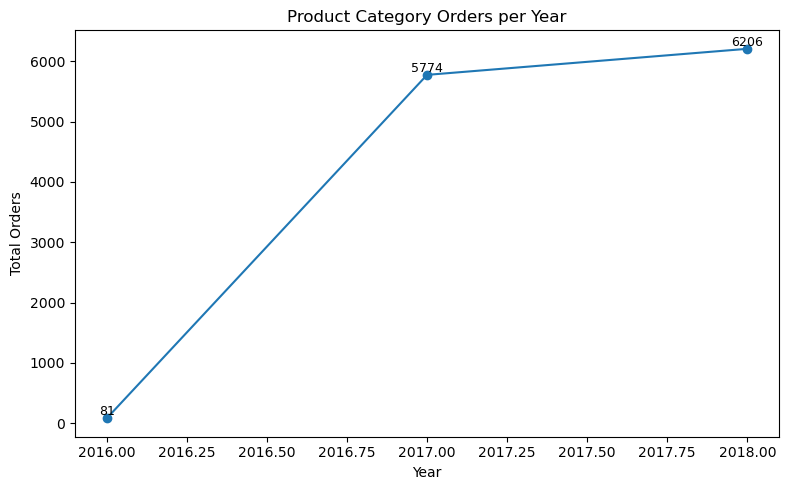

In [228]:
plt.figure(figsize=(8, 5))
plt.plot(df_top_category_trend['year'], df_top_category_trend['order_count'], marker='o')

# Menambahkan label pada setiap marker
for x, y in zip(df_top_category_trend['year'], df_top_category_trend['order_count']):
    plt.text(x, y + 50, str(y), ha='center', fontsize=9)  # Offset label agar tidak tumpang tindih dengan marker

plt.title('Product Category Orders per Year')
plt.xlabel('Year')
plt.ylabel('Total Orders')
plt.grid(False)
plt.tight_layout()
plt.show()

Dari grafik dapat dilihat pertumbuhan produk pertahun untuk kategori produk yang populer cukup tinggi dari tahun 2016 hingga 2018

# Review Customer

## Skor ulasan rata-rata untuk setiap pelanggan

In [230]:
df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce') 
df_review = df.groupby('customer_id').agg(review_avg=('review_score', 'mean'))
df_review.sort_values('review_avg',ascending=False)

,review_avg
customer_id,
ffffe8b65bbe3087b653a978c870db99,5.0
7bf43e2d079beb839eaff3937bb6fe81,5.0
7ba6760dc784ed6b1aeabe0500dc40b8,5.0
dcd807e8478e48fc1ea524e8d2fc1b79,5.0
7ba7a7ead798304838e37ed1872dea66,5.0
...,...
2366d8efd1501a7983ee949c05a7d2d8,0.0
47aea8cecc6638f35d43b8115a23b632,0.0
2f32a584ced80167b95fa5b259801864,0.0


### Tingkat kepuasan setiap pelanggan

In [234]:
#asumsi skor 4 & 5 puas, jika tidak, tidak puas
df_review['review_level']=pd.cut(df_review['review_avg'],bins=[0,3.9,np.inf],labels=['Tidak Puas','Puas'],right=True)
df_review

,review_avg,review_level
customer_id,,
00012a2ce6f8dcda20d059ce98491703,1.0,Tidak Puas
000161a058600d5901f007fab4c27140,4.0,Puas
0001fd6190edaaf884bcaf3d49edf079,5.0,Puas
0002414f95344307404f0ace7a26f1d5,5.0,Puas
000379cdec625522490c315e70c7a9fb,4.0,Puas
...,...,...
fffecc9f79fd8c764f843e9951b11341,3.0,Tidak Puas
fffeda5b6d849fbd39689bb92087f431,4.0,Puas
ffff42319e9b2d713724ae527742af25,5.0,Puas


In [236]:
#ringkasan statistik customer review
df_review.groupby('review_level').agg({'review_avg':['min','max','mean','median','count']})

C:\Users\sahar\AppData\Local\Temp\ipykernel_13360\2362610579.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_review.groupby('review_level').agg({'review_avg':['min','max','mean','median','count']})


review_avg                             
                    min  max      mean median  count
review_level                                        
Tidak Puas          1.0  3.5  1.861861    1.5  22645
Puas                4.0  5.0  4.749491    5.0  76028

Dilihat dari hasil analisa pelanggan tidak puas lebih banyak daripada pelanggan yang puas, untuk meningkatkan kepuasan pelanggan dapat dilakukan:
1. Analisis Akar Masalah dari Review Negatif, cari tahu topik dominan: produk rusak, pengiriman lambat, layanan buruk, dll.
2. Perbaiki Proses Pengiriman
3. Tingkatkan Kualitas Produk
4. Perbaiki Layanan Pelanggan (Customer Service)
5. Kumpulkan Feedback Positif secara Aktif

## Total ulasan setiap pelanggan

In [242]:
#total ulasan untuk setiap pelanggan
df_review_activity = df.groupby('customer_id').agg({
    'review_comment_title': lambda x: x.notnull().sum(),
    'review_comment_message': lambda x: x.dropna().str.strip().mask(lambda s: s == '').dropna().count(),
    'order_id': 'count'
}).sort_values('customer_id', ascending=False)

In [249]:
#ganti nama kolom comment title dan comment massage
df_review_activity = df.groupby('customer_id').agg({
    'review_comment_title': lambda x: x.notnull().sum(),
    'review_comment_message': lambda x: x.dropna().str.strip().mask(lambda s: s == '').dropna().count(),
    'order_id': 'count'
}).rename(columns={
    'review_comment_title': 'count_title_filled',
    'review_comment_message': 'count_message_filled'})

In [250]:
df_review_activity

,count_title_filled,count_message_filled,order_id
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,1,1,1
000161a058600d5901f007fab4c27140,1,0,1
0001fd6190edaaf884bcaf3d49edf079,1,1,1
0002414f95344307404f0ace7a26f1d5,1,0,1
000379cdec625522490c315e70c7a9fb,1,0,1
...,...,...,...
fffecc9f79fd8c764f843e9951b11341,3,0,3
fffeda5b6d849fbd39689bb92087f431,1,0,1
ffff42319e9b2d713724ae527742af25,1,1,1


In [251]:
#Hitung total order per customer:
df_order_count = df.groupby('customer_id').agg(
    total_orders=('order_id', 'count'))
df_order_count

,total_orders
customer_id,
00012a2ce6f8dcda20d059ce98491703,1
000161a058600d5901f007fab4c27140,1
0001fd6190edaaf884bcaf3d49edf079,1
0002414f95344307404f0ace7a26f1d5,1
000379cdec625522490c315e70c7a9fb,1
...,...
fffecc9f79fd8c764f843e9951b11341,3
fffeda5b6d849fbd39689bb92087f431,1
ffff42319e9b2d713724ae527742af25,1


In [252]:
#Gabungkan dua tabel:
df_combined = df_review_activity.join(df_order_count, how='inner')

#Hitung rasio review per transaksi:
df_combined['review_ratio'] = (
    (df_combined['count_title_filled'] + df_combined['count_message_filled']) / df_combined['total_orders'])
df_combined

,count_title_filled,count_message_filled,order_id,total_orders,review_ratio
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,1,1,1,1,2.0
000161a058600d5901f007fab4c27140,1,0,1,1,1.0
0001fd6190edaaf884bcaf3d49edf079,1,1,1,1,2.0
0002414f95344307404f0ace7a26f1d5,1,0,1,1,1.0
000379cdec625522490c315e70c7a9fb,1,0,1,1,1.0
...,...,...,...,...,...
fffecc9f79fd8c764f843e9951b11341,3,0,3,3,1.0
fffeda5b6d849fbd39689bb92087f431,1,0,1,1,1.0
ffff42319e9b2d713724ae527742af25,1,1,1,1,2.0


In [253]:
import plotly.express as px

In [254]:
df['total_orders'] = df.groupby('customer_id')['order_id'].transform('count')

In [255]:
funnel_data = {
    'review_activity': ['total_orders','review_score', 'count_title_filled', 'count_message_filled'],
    'unique_customers': [df[df['total_orders'].notna()]['customer_id'].nunique(),
        df[df['review_score'].notna()]['customer_id'].nunique(),
        df[df['review_comment_title'].dropna().str.strip().ne('').values]['customer_id'].nunique(),
        df[df['review_comment_message'].dropna().str.strip().ne('').values]['customer_id'].nunique()]}

funnel_df = pd.DataFrame(funnel_data)
funnel_df['unique_customers'] = funnel_df['unique_customers'].fillna(0).astype(int)
funnel_df['Conversion_Rate'] = funnel_df['unique_customers'] / funnel_df['unique_customers'].iloc[0]

funnel_df

,review_activity,unique_customers,Conversion_Rate
0,total_orders,99441,1.000000
1,review_score,99441,1.000000
2,count_title_filled,12319,0.123883
3,count_message_filled,41577,0.418107


In [256]:
funnel_df['Label'] = funnel_df['unique_customers'].astype(str) + ' (' + (funnel_df['Conversion_Rate'] * 100).round(1).astype(str) + '%)'

fig = px.funnel(funnel_df, x='unique_customers', y='review_activity', text='Label', title='Funnel with Conversion Rates')
fig.show()

Kesimpulan Analisis Funnel Review Pelanggan: 
1. Semua pelanggan yang melakukan pembelian (total_orders) juga memberikan skor ulasan (review_score).
   Menandakan bahwa review score diisi secara otomatis atau wajib setelah transaksi.
2. Hanya sebagian kecil yang mengisi kolom judul ulasan (review_comment_title). Hanya 11.8% pelanggan menulis judul review.
   Artinya judul ulasan bersifat opsional, dan tidak banyak pelanggan tertarik menulisnya.
3. Lebih banyak pelanggan mengisi pesan review (review_comment_message) dibandingkan judul.
   Sekitar 41.1% pelanggan memberikan komentar isi pesan.
4. Pelanggan lebih nyaman menulis pesan langsung tanpa memberi judul, atau mungkin judul dianggap tidak penting.
5. Mayoritas pelanggan (sekitar 59%) tidak menulis ulasan sama sekali (hanya memberikan skor).
   Perlu strategi khusus jika ingin mendorong pelanggan menulis ulasan lebih lengkap (misalnya, reminder atau insentif).

Rekomendasi Bisnis:
1. Optimalkan sistem review: pertimbangkan untuk menyederhanakan proses atau memberi motivasi agar pelanggan menulis komentar.
2. Fokus utama pada review_comment_message dibanding title, karena tingkat partisipasinya jauh lebih tinggi.
3. Gunakan data pesan ulasan untuk analisis sentimen atau masukan langsung dari pelanggan.

# Time Series Analysis

## Total penjualan setiap barang per hari

In [265]:
# Agregasi penjualan harian
df['order_date'] = df['order_purchase_timestamp'].dt.date  # ambil tanggal tanpa jam
df_daily_sales = df.groupby('order_date').agg({'total_order_value': 'sum'}).reset_index()
df_daily_sales.columns = ['date', 'daily_sales']
df_daily_sales

,date,daily_sales
0,2016-09-04,136.23
1,2016-09-05,75.06
2,2016-09-13,0.00
3,2016-09-15,143.46
4,2016-10-02,109.34
...,...,...
629,2018-09-29,0.00
630,2018-10-01,0.00
631,2018-10-03,0.00
632,2018-10-16,0.00


NameError: name 'mdates' is not defined

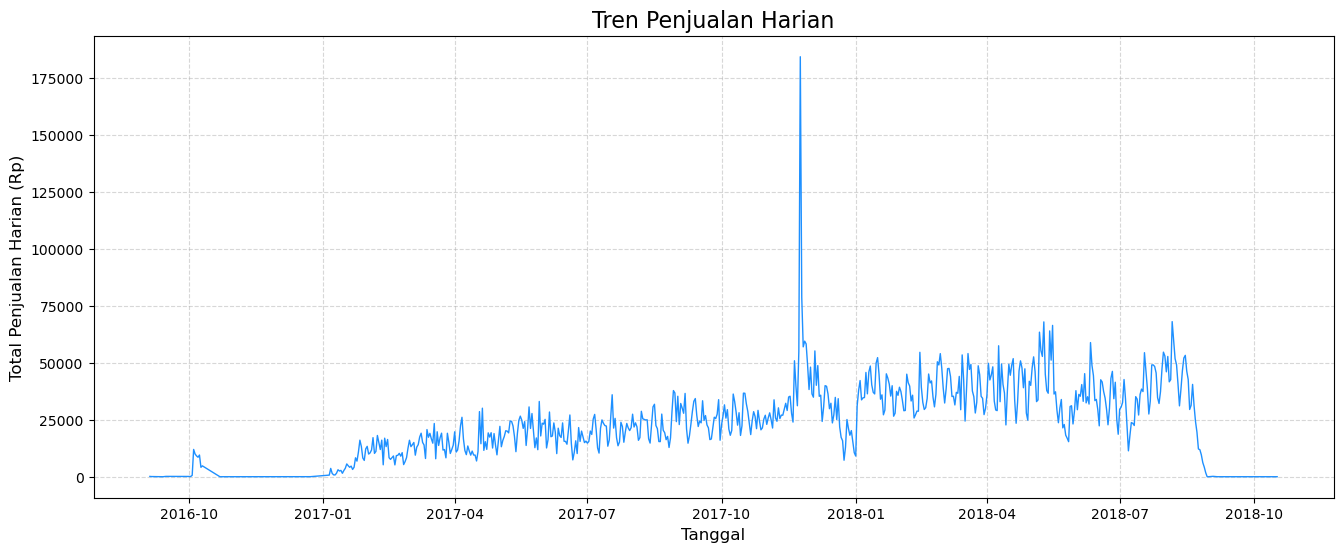

In [267]:
# Plot tren penjualan harian
plt.figure(figsize=(16, 6))
plt.plot(df_daily_sales['date'], df_daily_sales['daily_sales'], color='dodgerblue', linewidth=1)

# Tambahan styling
plt.title('Tren Penjualan Harian', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Penjualan Harian (Rp)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Format sumbu x agar lebih terbaca
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Dari grafik yang ada dapat dilihat bahwa data penjualan harian sangat fluktuatif
1. Diakhir 2016 hingga awal 2017: Penjualan masih kecil.
2. Pertengahan 2017 hingga 2018: Ada peningkatan bertahap dan beberapa lonjakan tajam, menandakan pertumbuhan.
3. Akhir 2018: Ada penurunan atau fluktuasi tidak menentu, bisa jadi karena musim, promosi, atau faktor eksternal lainnya.

Rekomendasi yang dapat diberikan berdasarkan pola tren:
1. Jika tren meningkat:
   * Pertahankan strategi pemasaran yang sudah berhasil.
   * Tambah stok, variasi produk, dan kerja sama dengan seller yang performanya tinggi.
   * Fokus ke segmentasi pelanggan yang loyal atau sering belanja ulang.
2. Jika tren menurun:
   * Evaluasi kampanye marketing dan harga.
   * Periksa apakah ada masalah pengiriman, ulasan negatif, atau ketidakpuasan pelanggan.
   * Lakukan promosi musiman, diskon bundling, atau free shipping untuk menarik kembali pembeli.
3. Jika tren stagnan:
   * Eksplorasi segmen pasar baru (misal: kota lain, kategori produk baru).
   * Tambahkan fitur loyalitas seperti poin reward atau program referral.

## Analisis musiman total pesanan per hari

In [269]:
# Hitung total pesanan per hari
df_orders_by_day = df.groupby('day_name').agg({'order_id': 'count'}).reset_index()
df_orders_by_day.columns = ['day_name', 'total_orders']

# Urutkan sesuai urutan hari
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_orders_by_day['day_name'] = pd.Categorical(df_orders_by_day['day_name'], categories=ordered_days, ordered=True)
df_orders_by_day = df_orders_by_day.sort_values('day_name')
df_orders_by_day

,day_name,total_orders
1,Monday,19366
5,Tuesday,19315
6,Wednesday,18640
4,Thursday,17826
0,Friday,17006
2,Saturday,12894
3,Sunday,14096


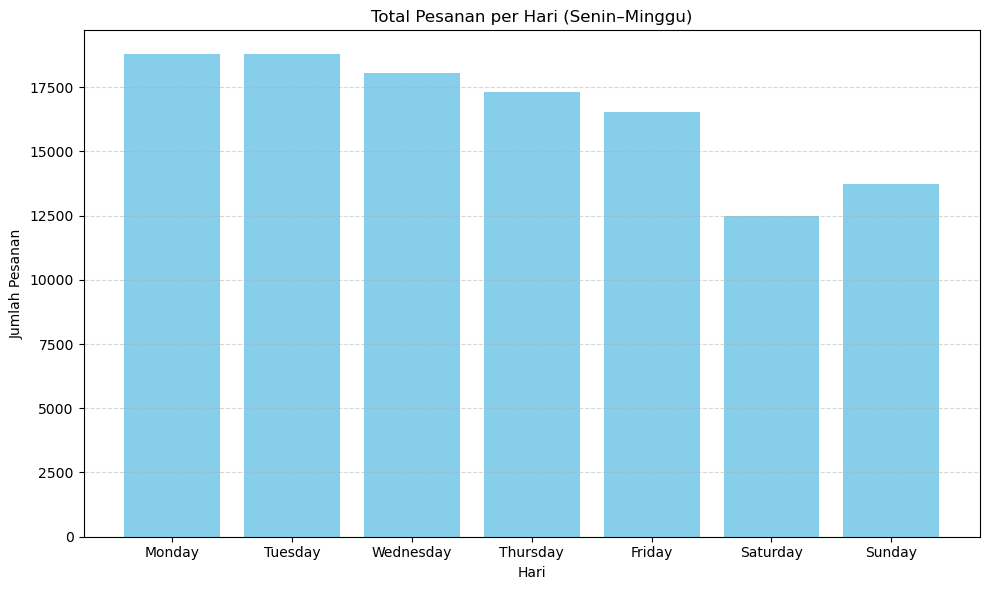

In [247]:
plt.figure(figsize=(10, 6))
plt.bar(df_orders_by_day['day_name'], df_orders_by_day['total_orders'], color='skyblue')
plt.title('Total Pesanan per Hari (Senin–Minggu)')
plt.xlabel('Hari')
plt.ylabel('Jumlah Pesanan')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Dilihat bahwa puncaknya pembelian terjadi pada hari Senin—Jum'at menunjukkan perilaku belanja konsumen terjadi pada hari kerj.
Pada hari Sabtu dan Minggu pembelian cenderung minim hal ini bertentangan dengan pola umum yang biasanya ramai di akhir pekan. 
Hal ini bisa disebabkan oleh:
1. Konsumen utama adalah karyawan atau pelaku usaha yang belanja kebutuhan operasional di hari kerja.
2. Promosi dan aktivitas pemasaran lebih aktif saat weekday.
3. Barang yang dijual lebih cocok untuk kebutuhan rutin, bukan hiburan atau konsumsi pribadi di akhir

Rekomendasi Strategi Bisnis Berdasarkan Pola Ini
1. Optimalkan Promosi Weekday
   * Fokuskan promosi dan kampanye digital pada hari Senin–Jumat, terutama jam kerja (09.00–17.00).
   * Gunakan email marketing atau notifikasi untuk mengingatkan pelanggan tentang promo khusus weekday.
2. Dorong Penjualan Weekend (Strategi Push)
   * Buat program promosi khusus Sabtu-Minggu untuk menarik transaksi, seperti:
   * Diskon khusus weekend
   * Gratis ongkir hanya di akhir pekan
   * Flash sale terbatas waktu
   * Kolaborasi dengan influencer atau konten hiburan di hari Sabtu–Minggu untuk meningkatkan awareness.
3. Segmentasi Waktu Posting Konten
   * Jadwal upload konten atau iklan difokuskan pada:
   * Pagi hari (08.00–10.00) saat orang memulai kerja.
   * Sore (15.00–17.00) saat istirahat atau menjelang pulang.
4. Logistik & Operasional
   * Jadwalkan pengiriman utama di weekday, karena tingkat permintaan tinggi.
   * Gunakan hari weekend untuk re-stock, maintenance, atau perencanaan strategi.